# Find lane lines

In [61]:
import math
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import os, sys
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



# Util functions

In [102]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
#     for line in lines:
#         x1,y1,x2,y2 = line
#         cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     return

    if lines is None:
        return
    if len(lines) == 0:
        return
    
    slope_threshold = 0.5
    right_lines = []
    left_lines = []
    img_x_center = img.shape[1] / 2  # x coordinate of center of image
    for line in lines:
        x1, y1, x2, y2 = line
        if x1==x2 or y1==y2:
            continue # ignore both vertical and horizontal line
        slope = (y2 - y1) / (x2 - x1)
        if abs(slope) > slope_threshold:
            #right lane
            if slope > 0 and x1 > img_x_center and x2 > img_x_center:
                right_lines.append(line)
            #left lane
            elif slope < 0 and x1 < img_x_center and x2 < img_x_center:
                left_lines.append(line)

    right_slope, right_intercept = average_slope_intercept(right_lines)
    left_slope, left_intercept = average_slope_intercept(left_lines)
    
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.65

    line_right = make_line_points(y1, y2, right_slope, right_intercept)
    line_left = make_line_points(y1, y2, left_slope, left_intercept)


    # Draw the right and left lines on image
    if right_slope != 1 and right_intercept != 1:
        cv2.line(img, line_right[0], line_right[1], color, thickness)
    if left_slope != 1 and left_intercept != 1:
        cv2.line(img, line_left[0], line_left[1], color, thickness)  

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    line_arr = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # Iterate over the output "lines" and draw lines on the blank
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # if can't find any lines
    if line_arr is None:
        return img
    
    line_arr = np.squeeze(line_arr)
    draw_lines(line_img, line_arr, thickness=10)
    return line_img


def weighted_img(img, initial_img, α=0.9, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def make_line_points(y1, y2, slope, intercept):
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def average_slope_intercept(lines):
    lines_x = []
    lines_y = []
    for line in lines:
        x1, y1, x2, y2 = line
        lines_x.append(x1)
        lines_x.append(x2)
        lines_y.append(y1)
        lines_y.append(y2)

    if len(lines_x) > 0:
        # fitting polynomial of degree 1
        slope, intercept = np.polyfit(lines_x, lines_y, 1)  # y = m*x + b
    else:
        slope, intercept = 1, 1
    return (slope, intercept)

def draw_images(images, cmap=None, savefile=False):
    cols = 2
    rows = (len(images)+1)//cols
    
    fig = plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
    if savefile == True:
        plt.savefig('test_images_output/output.png')
        plt.close(fig)
    else:
        plt.show()
    

# Process image pipeline

In [103]:
def process_image(image):
    height, width = image.shape[:2]

    p1 = (0, height)
    p2 = (width / 2 - 45, height / 2 + 60)
    p3 = (width / 2 + 45, height / 2 + 60)
    p4 = (width , height)

    #Step 1 Convert image to grayscale
    grey_img = grayscale(image)
    #Step 2 Use Gaussian blur to grayscale image
    blur_img = gaussian_blur(grey_img, 3)
    #Step 3 Canny Edge Detetion
    canny_img = canny(blur_img, 100, 255)
    #step 4 Apply region of interest mask
    vertices = np.array([[p1, p2, p3, p4]],dtype=np.int32)
    roi_img = region_of_interest(canny_img, vertices)

    #Step 5 Preform Hough Transform Line Detection
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_length = 30
    max_line_gap = 300

    hough_lines_img = hough_lines(roi_img, rho, theta, threshold, min_line_length, max_line_gap)
    #Step 6 Add highlighted lane lines to the original image
    result_img = weighted_img(hough_lines_img, image)
    return result_img

def process_video(input_video, output_video):
    white_output = 'test_videos_output/'+output_video
    clip1 = VideoFileClip("test_videos/"+input_video)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

# Test a single image

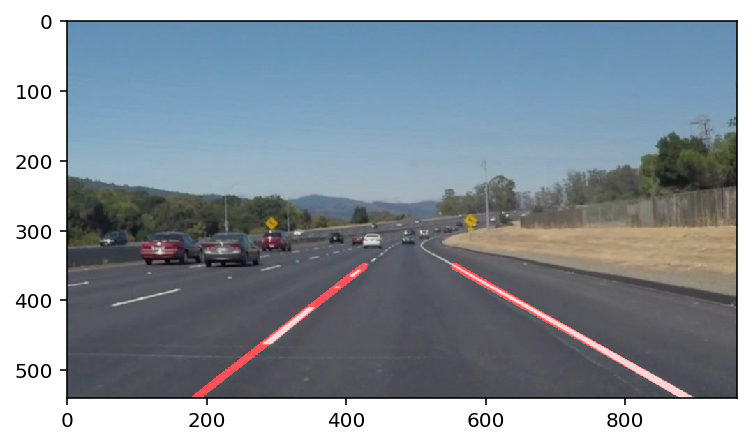

In [104]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
result_img = process_image(image)
plt.imshow(result_img)

# Test all images under test_images folder

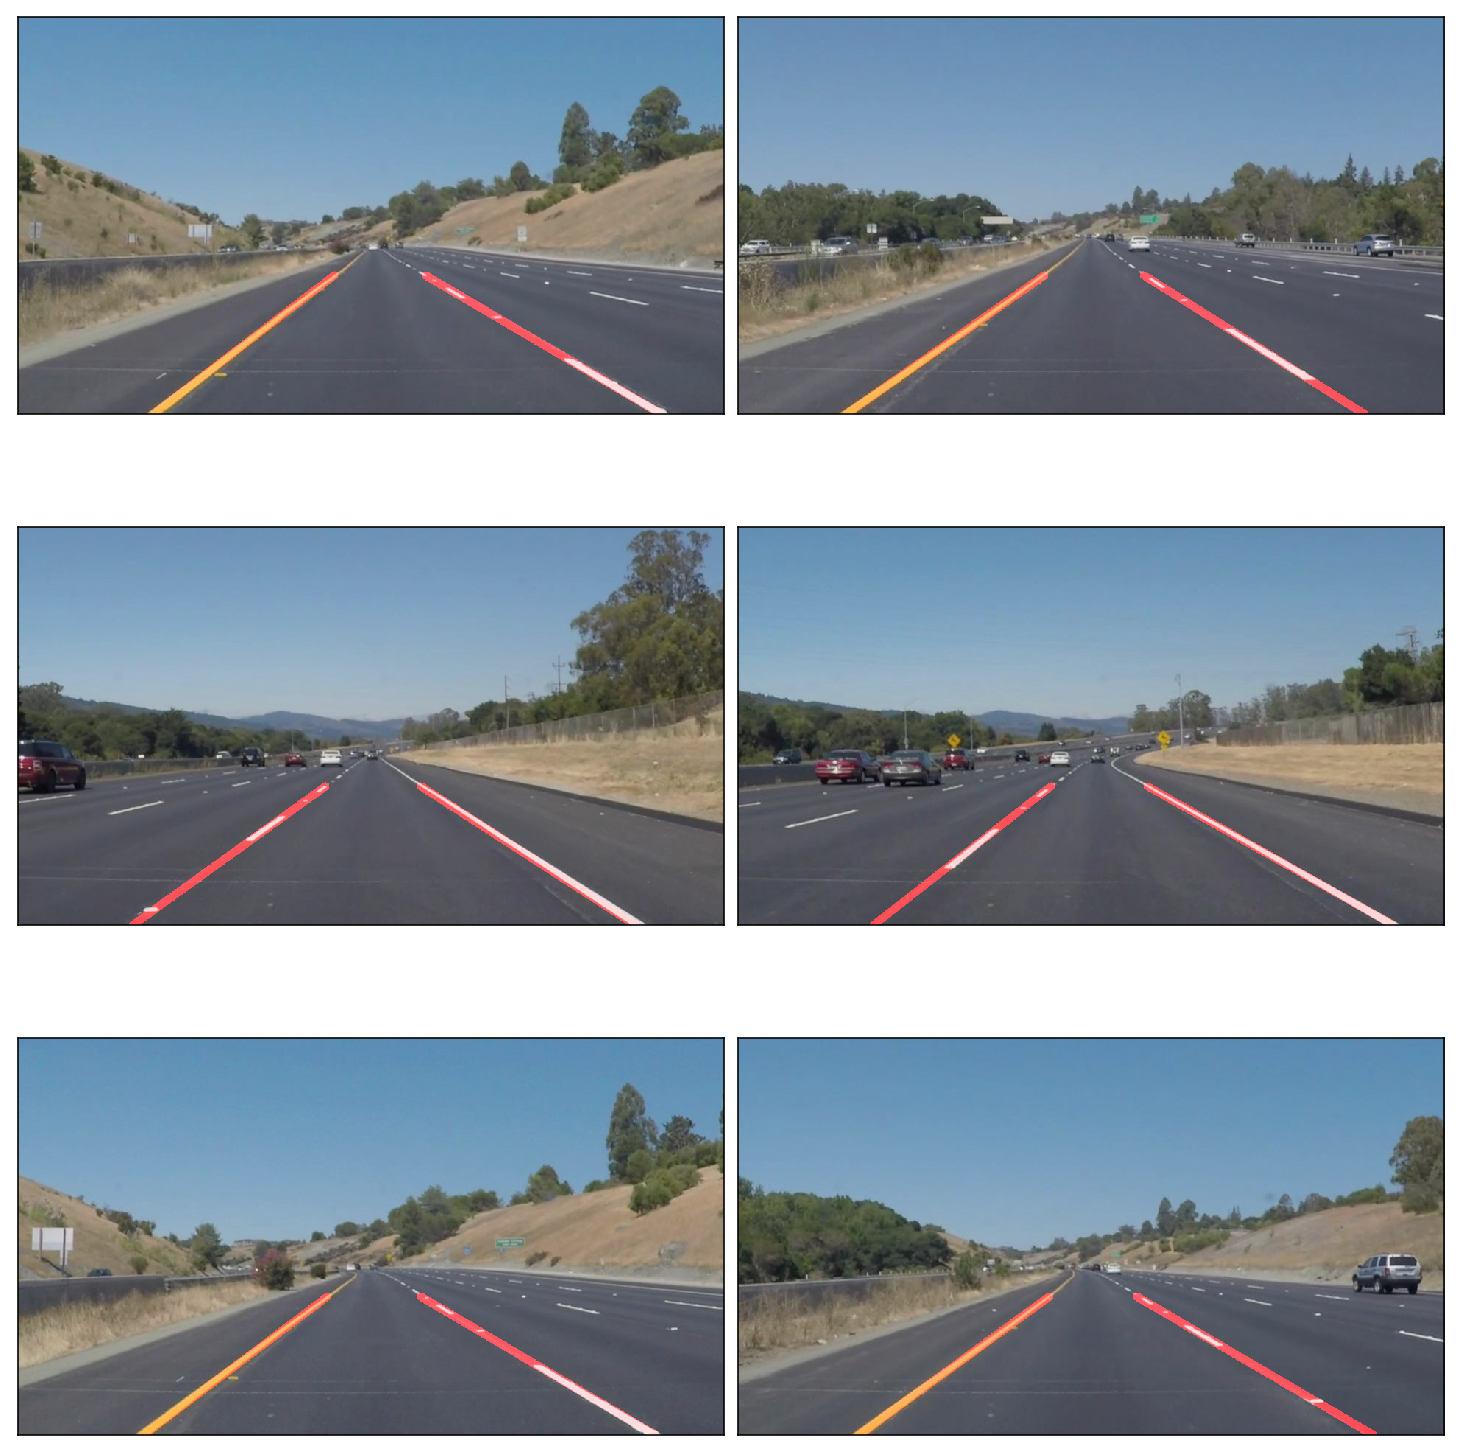

CPU times: user 3.82 s, sys: 10 ms, total: 3.83 s
Wall time: 3.84 s


In [101]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
line_images = []
for image in test_images:
    result_img = process_image(image)
    line_images.append(result_img) 
%time draw_images(line_images, savefile=False)

# Test Video Clips



In [89]:
%time process_video('solidWhiteRight.mp4', 'output_solidWhiteRight.mp4')

[MoviePy] >>>> Building video test_videos_output/output_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/output_solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 39.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_solidWhiteRight.mp4 

CPU times: user 876 ms, sys: 145 ms, total: 1.02 s
Wall time: 5.84 s
CPU times: user 877 ms, sys: 254 ms, total: 1.13 s
Wall time: 6.15 s


In [48]:
%time process_video('solidYellowLeft.mp4', 'output_solidYellowLeft.mp4')

[MoviePy] >>>> Building video test_videos_output/output_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/output_solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 14.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_solidYellowLeft.mp4 

CPU times: user 8.38 s, sys: 711 ms, total: 9.1 s
Wall time: 47.5 s
CPU times: user 8.39 s, sys: 807 ms, total: 9.2 s
Wall time: 47.8 s


In [49]:
%time process_video('challenge.mp4', 'output_challenge.mp4')

[MoviePy] >>>> Building video test_videos_output/output_challenge.mp4
[MoviePy] Writing video test_videos_output/output_challenge.mp4


100%|██████████| 251/251 [00:32<00:00,  7.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_challenge.mp4 

CPU times: user 5.7 s, sys: 462 ms, total: 6.17 s
Wall time: 36.5 s
CPU times: user 5.74 s, sys: 543 ms, total: 6.28 s
Wall time: 36.9 s
